次は、金融市場でありがちな戦略に基づいて売買して、その成績に応じて戦略をまねさせる、バージョンを作りたい

### 前提条件

・対数正規分布に従うような企業の規模の変動

・企業規模に比例した「均衡」株価

・採用する戦略の種類は、同時に一種類のみ

・採用する戦略内で、パラメータ調整。パラメータは独自に振動しつつ、収益率の高いエージェントの真似をする傾向も加える

・預金×レバレッジが、買うための資金源

・いずれの戦略でも、ポートフォリオ配分割合目標を持つ

・配当（企業の潜在価値の一定割合）と税（利益の一定割合）と非金融所得（外生的、一定、全エージェント）の導入


### 戦略（案）

・ファンダメンタルズに応じて売買する。長期的戦略。

・テクニカル分析に応じて売買する。短期的戦略。

・テクニカル分析に応じて売買する。長期的戦略。


In [1]:
using StatsPlots
using Random
using Statistics

In [2]:
mutable struct Agent
    strategy::String
    money::Float64
    sharesQuantity  #   株式保有部数リスト
    sharesRetainedLine  #   株式保有金額のリスト
    total_assets_log    #   資産総額の履歴
    params  #   パラメータのリスト  
    #   ファンダメンタルズ戦略をとる場合 [ポートフォリオに占める預金の割合の目標, 企業評価/時価総額　の、買いの閾値になる倍率, 企業価値/時価総額　の、売りの閾値になる倍率, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    #   インデックス戦略をとる場合      [ポートフォリオに占める預金の割合の目標, 1期のタイムスケール, α5, α4, α3, α2, α1, α0, β1, β2, γ, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    fundamentals    #   企業評価のリスト    ファンダメンタルズ戦略をとる場合しか使わないが、更新はインデックス戦略をとるときでも続ける
    portfolio_target#   ポートフォリオ配分目標。[預金,株式]
    purchase_cost
    performance::Float64    #   運用成績
end
mutable struct Firm
    stockPrice::Float64     #   株価
    stockQuantity::Float64  #   株式発行部数
    stockPriceLog   #   価格の記録
    stockQuantityLog    #   発行部数の記録
    marketCapitalization::Float64   #   時価総額
    hiddenCorporateValue::Float64   #   企業規模
    buy_offers  #   買い注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
    sell_offers #   売り注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
end
function update_hiddenCorporateValue(firms, ft)
    σ_r, σ, μ = 0.02, 2.0, log(100.0*ft)
    σ_p = sqrt(σ^2 + σ_r^2)
    for firm in firms
        f = firm.hiddenCorporateValue
        firm.hiddenCorporateValue = exp((log(f) + σ_r*randn())*σ/σ_p + μ*(1 - σ/σ_p))
    end
end
function update_estimate_corporateValue(agents, firms)
    for agent in agents
        for (i, estimated_value) in enumerate(agent.fundamentals)
            agent.fundamentals[i] = (0.02*firms[i].hiddenCorporateValue + 0.98*estimated_value) * exp(0.1*randn())
        end
    end
end
function update_portfolio_target(agents)
    for agent in agents
        if agent.total_assets_log[end] <= 0
            agent.portfolio_target[1:2] = [0,0]
            continue
        end
        agent.portfolio_target[1] = agent.total_assets_log[end] * agent.params[1]
        agent.portfolio_target[2] = agent.total_assets_log[end] * (1 - agent.params[1])
    end
end
function cal_total_asset(agents)
    for agent in agents
        push!(agent.total_assets_log, sum(agent.sharesRetainedLine) + agent.money)
    end
end
function cal_sharesRetainedLine(agents, firms)
    for agent in agents
        for i = 1:size(agent.sharesQuantity)[1]
            agent.sharesRetainedLine[i] = firms[i].stockPrice*agent.sharesQuantity[i]
        end
    end
end
function fundamentals_trade_offer(agent, firms, j)
    lst = []
    marketCap, mean_ln_amp, fundamentals_sum = 0.0, 0.0, 0.0
    for (i, firm) in enumerate(firms)
        marketCap = firm.marketCapitalization
        fundamentals = agent.fundamentals[i]
        push!(lst, (marketCap/fundamentals, i))    #   marketCap/fundamentalsが小さいほど買いたい、大きいほど売りたい
        mean_ln_amp += log(marketCap/fundamentals)
        fundamentals_sum += fundamentals
    end
    mean_ln_amp /= size(firms)[1]
    sort!(lst)
    sell, buy = [], []
    #   全部売り候補に入れて、ポートフォリオ配分目標に至るまで買い候補に入れて、その差額を本チャンの売買リストに加える
    #   すべて仮売り。
    for (i,q) in enumerate(agent.sharesQuantity)
        if q > 0.0
            p = min(firms[i].stockPrice, (0.2*exp(mean_ln_amp)*agent.fundamentals[i] + 0.8*firms[i].marketCapitalization)/(firms[i].stockQuantity))
            push!(sell, (i, p, q))
        end
    end
    #   仮買い。
    allocations_lst = [0.0 for _ = 1:size(firms)[1]]
    for k in 1:min(Integer(agent.params[end]), size(firms)[1])
        _, i = lst[k]
        allocations_lst[i] = agent.portfolio_target[2]*agent.fundamentals[i]/fundamentals_sum
    end
    for k in 1:min(Integer(agent.params[end]), size(firms)[1])
        _, i = lst[k]
        p = (0.2*exp(mean_ln_amp)*agent.fundamentals[i] + 0.8*firms[i].marketCapitalization)/(firms[i].stockQuantity)
        q = allocations_lst[i]/p
        push!(buy, (i, p, q))
    end
    #   注文の決定
    going_to_buy_price = 0.0
    for (ib, pb, qb) in sell
        q, p = qb, pb
        for (is, ps, qs) in buy
            if ib == is
                q -= qs
                if q < 0.0
                    p = ps
                end
                break
            end
        end
        if q > 0
            push!(firms[ib].sell_offers, (p, q, j))
        elseif q < 0
            going_to_buy_price += p*(-q)
            if going_to_buy_price > agent.money
                continue
            end
            push!(firms[ib].buy_offers, (p, -q, j))
        end
    end
end
function chart_trade_offer(agent, firms, j)
    span = agent.params[2]
    if size(firms[1].stockPriceLog)[1] < span*6
        return nothing
    end
    α5, α4, α3, α2, α1 = agent.params[3:7]
    α0 = agent.params[8]
    β1, β2 = agent.params[9:10]                #   β1<β2 の条件を追加する
    sell, buy = [], []
    for (i, firm) in enumerate(firms)
        x1, x2, x3, x4, x5, x6 = firm.stockPriceLog[end-5:end]
        p = sum([α0 + α1*(x2-x1)/x1, α2*(x3-x2)/x2, α3*(x4-x3)/x3, α4*(x5-x4)/x4, α5*(x6-x5)/x5])
        if p < β1
            push!(sell, (p,i))
        elseif p > β2
            push!(buy, (p,i))
        end
    end
    sort!(buy)
    sort!(sell, rev=true)
    going_to_buy_price, going_to_sell_price = 0, 0
    γ = agent.params[11]    #   総資産に占める目標取引量の割合
    γ2 = (1 - γ/2)*agent.total_assets_log[end]
    while γ2 > going_to_buy_price && size(buy)[1] > 0
        p, i = pop!(buy)
        price = (1+p)*firms[i].stockPrice
        if price <= 0
            continue
        end
        quantity = 1/agent.params[end]*agent.money/price
        going_to_buy_price += price*quantity
        if agent.money - going_to_buy_price < 0.5*agent.portfolio_target[1]
            break
        end
        push!(firms[i].buy_offers, (price, quantity, j))
    end
    while agent.money + going_to_sell_price - going_to_buy_price < agent.portfolio_target[1] && size(sell)[1] > 0
        p, i = pop!(sell)
        price = (1+p)*firms[i].stockPrice
        quantity = agent.sharesQuantity[i]
        if price <= 0.0 || quantity == 0.0
            continue
        end
        going_to_buy_price += price*quantity
        push!(firms[i].sell_offers, (price, quantity, j))
    end
end
function trade_offer(agents, firms)
    for firm in firms
        firm.buy_offers, firm.sell_offers = [], []
    end
    for (j, agent) in enumerate(agents)
        if agent.strategy == "fundamentals"
            fundamentals_trade_offer(agent, firms, j)
        elseif agent.strategy == "chart"
            chart_trade_offer(agent, firms, j)
        end
    end
end
function cal_performance(agents, income)
    for agent in agents
        agent.performance = (agent.total_assets_log[end] - agent.total_assets_log[end-1] - income)/agent.total_assets_log[end-1]
    end
end
function trade_matching(agents, firms)
    for (i, firm) in enumerate(firms)
        buy, sell = firm.buy_offers, firm.sell_offers
        sort!(buy)
        sort!(sell, rev=true)
        selling_p, selling_q, buying_p, buying_q = 0.0, 0.0, 0.0, 0.0
        trading_p = firm.stockPrice
        pb, qb, jb, ps, qs, js = 0.0, 0.0, -1, 0.0, 0.0, -1
        while buying_p >= selling_p
            if size(buy)[1] == 0 || size(sell)[1] == 0
                break
            end
            if buying_q == 0.0
                pb, qb, jb = pop!(buy)
                buying_q = qb
                buying_p = pb
            end
            if selling_q == 0.0
                ps, qs, js = pop!(sell)
                selling_q = qs
                selling_p = ps
            end
            if buying_p < selling_p
                break
            end
            trading_q = min(buying_q, selling_q)
            buying_q -= trading_q
            selling_q -= trading_q
            trading_p = (pb + ps)/2
            agents[jb].purchase_cost[i] = (agents[jb].purchase_cost[i]*agents[jb].sharesQuantity[i] + trading_p*trading_q)/(agents[jb].sharesQuantity[i] + trading_q)
            agents[jb].sharesQuantity[i] += trading_q
            agents[js].sharesQuantity[i] -= trading_q
            agents[jb].money -= trading_p*trading_q
            tax, tax_rate = 0.0, 0.2
            if agents[js].purchase_cost[i] < trading_p
                tax = tax_rate*trading_q*(trading_p - agents[js].purchase_cost[i])
            end
            agents[js].money += trading_p*trading_q - tax
        end
        firm.stockPrice = trading_p
        push!(firm.stockPriceLog, trading_p)
    end
end
function update_strategy(agents)
    if size(agents[1].total_assets_log)[1] < 10
        return nothing
    end
    A = Integer(size(agents)[1])
    for agent in agents
        teacher = rand(1:A)
        t0, t1 = agent.total_assets_log[end-9], agent.total_assets_log[end]
        if rand() < 0.01 - 0.01*(t1 - t0)/t0
            new_strategy = deepcopy(agents[teacher].strategy)
            agent.strategy = new_strategy
            new_params = append!([agent.params[1]], agents[teacher].params[2:end])
            agent.params = new_params
        end
    end
end
function update_params(agents)
    for agent in agents
        agent.params[1] += 0.01*randn()
        agent.params[1] = abs(agent.params[1])
        if agent.params[1] > 1
            agent.params[1] = 1 - agent.params[1] % 1
        end
        agent.params[end] += rand(-1:1)
        if agent.params[end] <= 0
            agent.params[end] = 1
        end
        if agent.strategy == "chart"
            if rand() < 0.01
                agent.params[2] += rand(-1:1) #   タイムスケール
                if agent.params[2] <= 0
                    agent.params[2] = 1
                end
            end
            agent.params[3:7] += 0.01*randn(5)
            agent.params[3:7] = (agent.params[3:7] .- sum(agent.params[3:7])/5)/(std(agent.params[3:7])*sqrt(5))
            agent.params[8] += 0.01*randn()
            agent.params[9:10] += 0.01*randn(2)
            if agent.params[9] > agent.params[10]
                agent.params[9], agent.params[10] = agent.params[10], agent.params[9]
            end
            agent.params[11] += 0.01*randn()
            if agent.params[11] < 0
                agent.params[11] = abs(agent.params[11] % 1)
            elseif agent.params[11] > 1
                agent.params[11] = 1 - agent.params[11] % 1
            end
        end
    end
end
function update_marketCapitalization(firms)
    for firm in firms
        firm.marketCapitalization = firm.stockPrice*firm.stockQuantity
    end
end
function get_income(agents, income)
    for agent in agents
        agent.money += income
    end
end
function get_dividend(agents, firms)
    Π = 0.2
    payout_ratio = 0.35
    for agent in agents
        for (i, q) in enumerate(agent.sharesQuantity)
            if q > 0.0
                dividend = q/firms[i].stockQuantity * Π*payout_ratio*firms[i].hiddenCorporateValue
                agent.money += dividend
            end
        end
    end
end
function run_one_term(agents, firms, income, ft)
    update_hiddenCorporateValue(firms, ft)
    update_estimate_corporateValue(agents, firms)
    trade_offer(agents, firms)
    trade_matching(agents, firms)
    get_dividend(agents, firms)
    cal_sharesRetainedLine(agents, firms)
    cal_total_asset(agents)
    cal_performance(agents, income)
    get_income(agents, income)
    update_strategy(agents)
    update_params(agents)
    update_portfolio_target(agents)
    update_marketCapitalization(firms)
end
function f(t)
    return 2^(0.01*t)
end

f (generic function with 1 method)

In [3]:
N, M = 10^2, 10 #   エージェント数, 株式会社数
init_stock_quantity, init_stock_price = 100.0, 1.0
init_money = init_stock_quantity*init_stock_price*M/N * 9.0
agents = [
    Agent(
        "chart",
        init_money,
        [init_stock_quantity/N for _ = 1:M],
        [init_stock_quantity*init_stock_price/N for _ = 1:M],
        [init_money/0.9],
        [0.9, 1, randn(), randn(), randn(), randn(), randn(), 0.0, -0.01, 0.01, 0.5, 5],
        [init_money*N/M for _ = 1:M],
        [init_money, 0.1*init_money],
        [1.0 for _ = 1:M],
        0.0,
    ) for j = 1:Int(floor(N/2))
]
for _ = 1:(N - Int(floor(N/2)))
    push!(agents, 
        Agent(
            "fundamentals",
            init_money,
            [init_stock_quantity/N for _ = 1:M],
            [init_stock_quantity*init_stock_price/N for _ = 1:M],
            [init_money/0.9],
            [0.9, 5],
            [init_money*N/M for _ = 1:M],
            [init_money, 0.1*init_money],
            [1.0 for _ = 1:M],
            0.0
        )
    )
end
firms = [
    Firm(
        init_stock_price,
        init_stock_quantity,
        [init_stock_price],
        [init_stock_quantity],
        init_stock_price*init_stock_quantity,
        init_stock_price*init_stock_quantity,
        [],
        [],
    ) for _ = 1:M
]

10-element Vector{Firm}:
 Firm(1.0, 100.0, [1.0], [100.0], 100.0, 100.0, Any[], Any[])
 Firm(1.0, 100.0, [1.0], [100.0], 100.0, 100.0, Any[], Any[])
 Firm(1.0, 100.0, [1.0], [100.0], 100.0, 100.0, Any[], Any[])
 Firm(1.0, 100.0, [1.0], [100.0], 100.0, 100.0, Any[], Any[])
 Firm(1.0, 100.0, [1.0], [100.0], 100.0, 100.0, Any[], Any[])
 Firm(1.0, 100.0, [1.0], [100.0], 100.0, 100.0, Any[], Any[])
 Firm(1.0, 100.0, [1.0], [100.0], 100.0, 100.0, Any[], Any[])
 Firm(1.0, 100.0, [1.0], [100.0], 100.0, 100.0, Any[], Any[])
 Firm(1.0, 100.0, [1.0], [100.0], 100.0, 100.0, Any[], Any[])
 Firm(1.0, 100.0, [1.0], [100.0], 100.0, 100.0, Any[], Any[])

In [4]:
money_sum = 0.0
for agent in agents
    money_sum += agent.money
end
money_sum

9000.0

In [5]:
T = 10^3
income_lst = [0.0002*init_money*f(t) for t = 1:T] 
#   income=constantだと、金融市場の規模が継続的に大きく（小さく）ならないためか、
#   適応の結果ポートフォリオ配分目標に占める預金の割合がとても大きくなる。そして売買が減り、値動きが激減する
@time for t = 1:T
    income = income_lst[t]
    run_one_term(agents, firms, income, f(t))
end

 25.079341 seconds (74.55 M allocations: 1.706 GiB, 4.14% gc time, 22.11% compilation time)


In [6]:
tmp = 0.0
j = 1
for i = 1:99
    tmp += 100*(firms[j].stockPriceLog[end-i] - firms[j].stockPriceLog[end-1-i])/firms[j].stockPriceLog[end-1-i]
end
tmp /= 99

0.7569654945132501

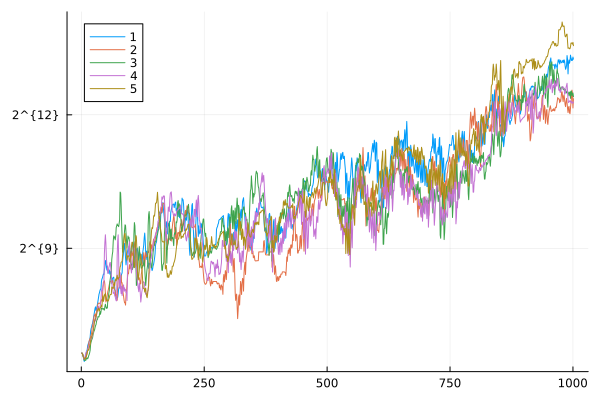

In [7]:
plot(firms[1].stockPriceLog.*firms[1].stockQuantityLog, label="1", yscale=:log2)
for i = 2:4
    plot!(firms[i].stockPriceLog.*firms[i].stockQuantityLog, label=string(i), yscale=:log2)
end
plot!(firms[5].stockPriceLog.*firms[5].stockQuantityLog, label=string(5), yscale=:log2)

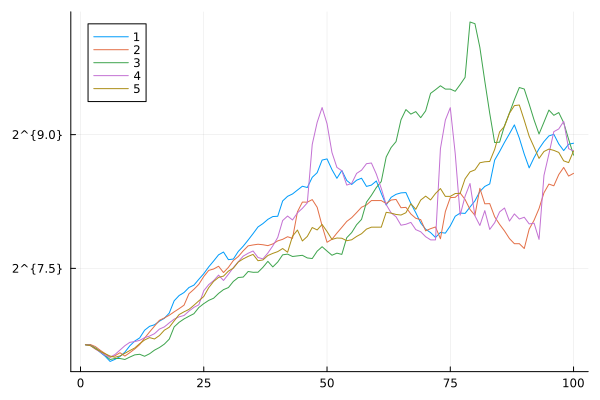

In [8]:
plot(firms[1].stockPriceLog[1:100].*firms[1].stockQuantityLog, label="1", yscale=:log2)
for i = 2:4
    plot!(firms[i].stockPriceLog[1:100].*firms[i].stockQuantityLog, label=string(i), yscale=:log2)
end
plot!(firms[5].stockPriceLog[1:100].*firms[5].stockQuantityLog, label=string(5), yscale=:log2)

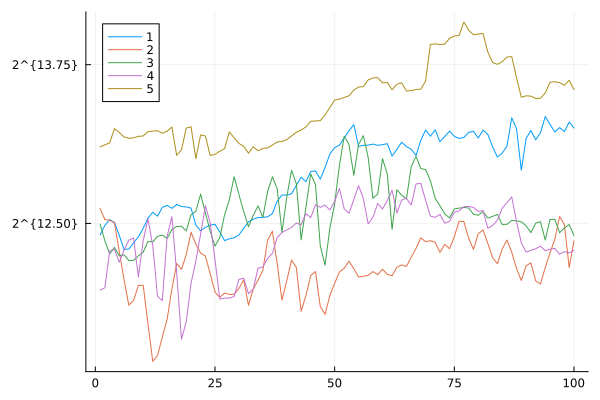

In [9]:
plot(firms[1].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label="1", yscale=:log2)
for i = 2:4
    plot!(firms[i].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label=string(i), yscale=:log2)
end
plot!(firms[5].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label=string(5), yscale=:log2)

In [10]:
for i = 1:10
    println(i, agents[i].portfolio_target)
end

1[4154.671180066998, 7282.948287982502]
2[2683.106445855899, 2047.2459815256736]
3[2240.604967217892, 1153.2142035886325]
4[2323.7701893962903, 440.3914892523552]
5[2264.763143967677, 1436.2576378407966]
6[1262.4565524007064, 1603.9017519267882]
7[2804.778560655775, 52.25057837413696]
8[2357.6303774446556, 643.5986966709078]
9[2262.71883490777, 510.9955191542306]
10[2665.8318953442717, 310.93883727796435]


In [11]:
agents

100-element Vector{Agent}:
 Agent("fundamentals", 8878.743669816402, [11.972987185576562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.095190845071895, 0.0, 5.354040890508892], [1167.1602410687856, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 476.0216815389499, 0.0, 934.125875625362], [100.0, 100.67120975811449, 101.16915404240484, 101.65286427447793, 102.11723140899669, 102.59140611858876, 103.0315966920683, 103.47015206438562, 103.85581538395705, 104.34669203188041  …  11084.243271561167, 11043.02201128249, 11071.087328309903, 11197.272300129549, 11244.652148528232, 11164.515862792756, 11272.007632274874, 11280.168502152072, 11425.18421179691, 11437.6194680495], [0.3632461450280711, 23.0], [139.98259323188915, 60.763824915645756, 114.57007567562228, 61.74791107056886, 144.8775489555759, 194.44794452410935, 91.78900545006401, 138.03857612381188, 107.21666382676489, 139.5779820314552], [4154.671180066998, 7282.948287982502], [38.031102434387996, 3.0871806674182203, 12.376143229697584, 12.680045149236092, 17.80711

In [12]:
firms

10-element Vector{Firm}:
 Firm(97.48279380728167, 100.0, [1.0, 0.9964727202894459, 0.9731399179279547, 0.9425221009761655, 0.9142331147902192, 0.8782694773679058, 0.8926177780837752, 0.9126915164252318, 0.9439177504546598, 0.9916574810394647  …  96.19579387487693, 91.41282005073464, 94.99797283961612, 103.80450043758705, 99.39974812488292, 95.4213079522877, 97.71794269549969, 95.63817759290659, 100.7072034850098, 97.48279380728167], [100.0], 9748.279380728167, 92.49836174704896, Any[(72.72940876504514, 0.7788267181445941, 39), (83.21212894950781, 0.5283655215165671, 94), (85.00479247037411, 1.473936408123669, 45), (88.66824064303037, 0.005682128092915836, 80), (91.38036295780839, 0.01120637220469986, 66), (92.98455060431698, 0.47574094496891806, 29), (95.30773204808226, 0.11401022148109725, 18), (96.44353753636454, 0.9372701953799096, 96), (96.52974250088066, 0.3257353547875361, 90), (96.61018135844435, 0.019273247211694267, 85), (96.82792486392772, 0.3396554111467126, 10), (97.0028751

In [13]:
money_sum = 0.0
for agent in agents
    money_sum += agent.money
end
money_sum

332738.9538319398

In [14]:
for firm in firms[1:10]
    println(firm.hiddenCorporateValue)
end

92.49836174704896
50.306290802859735
57.93268461180745
39.61472864419071
130.44480957652735
110.08255602344947
97.23818414002938
157.40707855558048
140.85153106975181
247.5007081486612


In [15]:
for firm in firms[1:10]
    println(firm.marketCapitalization)
end

9748.279380728167
5268.711301537562
5425.535958559607
4997.6446487108915
12024.680128640148
9214.174258310328
5775.26746207156
11623.91936170176
12320.584789434022
17447.118816019633


In [16]:
for agent in agents[1:10]
    println(agent.fundamentals)
end

[139.98259323188915, 60.763824915645756, 114.57007567562228, 61.74791107056886, 144.8775489555759, 194.44794452410935, 91.78900545006401, 138.03857612381188, 107.21666382676489, 139.5779820314552]
[171.99672954465223, 28.98000317637572, 91.59625388055495, 79.00277226436906, 417.46415396373607, 70.43503048478352, 30.26263126947179, 157.14766887654437, 135.26665788863806, 333.7241695878669]
[102.81223582742744, 48.16604517778969, 94.51371456997083, 52.70846468003408, 113.5811893898108, 173.3233365513283, 112.43271184723014, 137.0247203376019, 110.41562734682404, 104.91067615229032]
[201.72144166976761, 58.66469941055098, 127.51821810487823, 58.13663280942399, 163.11069503014005, 236.66187505132248, 65.14972236938912, 70.8752133038738, 173.5194934650022, 287.86839645813967]
[225.56377834999836, 44.128617247771366, 99.63965262341614, 143.1872729839479, 220.31847985215083, 123.64435130230389, 159.83498998004006, 214.31510135131938, 170.42642484747043, 195.0399932795555]
[76.56943212701076, 

In [17]:
for agent in agents[1:10]
    println(agent.params)
end

[0.3632461450280711, 23.0]
[0.5672106861054957, 2.0]
[0.6602016355177295, 5.0, 0.22177622838914532, -0.6859145036716753, -0.0635097293926371, 0.5256415953560402, 0.002006409319126893, -0.4019022538888988, -0.0628954327593393, 0.11232318877871235, 0.34618371130780246, 79.0]
[0.8406781004692694, 42.0]
[0.6119293236881039, 24.0]
[0.4404391978821029, 2.0, 0.5685403413060004, 0.26293971187281856, 0.017154282015377994, -0.5780054908379751, -0.2706288443562217, -0.018540092293809363, 0.14048567201833304, 0.29035353640274897, 0.3804216011555313, 13.0]
[0.9817115696650268, 8.0]
[0.7855549573933903, 10.0]
[0.8157721185651663, 3.0, 0.6091478074801789, 0.183416542823666, 0.08695741417974703, -0.461629369611883, -0.41789239487170904, -0.12621811922893753, 0.18335555884811444, 0.3198605850096351, 0.09573845328069551, 7.0]
[0.895544915881359, 1.0, 0.4150839720420107, -0.7201679771147761, 0.015236449185722022, 0.32771522834753153, -0.03786767246048806, -0.06724047423740859, -0.3985516051051681, -0.081

In [18]:
for agent in agents[1:10]
    println(agent.sharesQuantity)
end

[11.972987185576562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.095190845071895, 0.0, 5.354040890508892]
[0.0, 0.0, 0.0, 0.0, 3.329175753355446, 0.0, 0.0, 0.0, 0.0, 2.357040420379404

]
[0.0, 0.0, 0.0, 0.36307326799637935, 1.1207046936133689, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4559451605232422]
[1.970009284245215, 0.7319043998092251, 0.0, 0.0, 1.4992827447096688, 0.0, 0.0, 1.576370492579751, 0.8160575286013985, 1.0634890066156124]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.48651050298116977, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.883208838313359, 1.630941715442661, 3.6005750014964635, 1.87943243970861, 1.0994758302506973, 1.3199069367499723, 3.01344238427326, 1.0801654937328482, 0.4088795852127281, 0.9594293561958304]


In [19]:
for firm in firms[1:10]
    println(firm.stockQuantityLog)
end

[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
